In [1]:
import re
import pandas as pd
from collections import defaultdict

# sumy
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
 
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer

# NLTK stopwords
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +           # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")            # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read().replace('&rsquo;', "'").replace('&lsquo;', "'")
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&ldquo;', '"')
                                   .replace('&rdquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
stop_words = stopwords.words('english')

In [5]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path

In [13]:
def compute_coherence_values(dictionary, corpus, texts, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
start=5; stop=35; step=1;
stop += 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        stop=stop,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model
Calculating 35-topic model


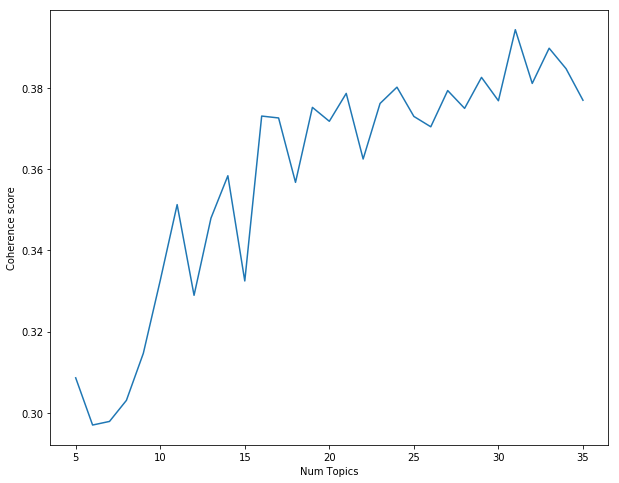

In [15]:
# Show graph
x = range(start, stop, step)
plt.figure(figsize=(10, 8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
idx = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6), '  Model index', idx)
    idx += 1

Num Topics = 5  has Coherence Value of 0.308636   Model index 0
Num Topics = 6  has Coherence Value of 0.297013   Model index 1
Num Topics = 7  has Coherence Value of 0.2979   Model index 2
Num Topics = 8  has Coherence Value of 0.303089   Model index 3
Num Topics = 9  has Coherence Value of 0.314669   Model index 4
Num Topics = 10  has Coherence Value of 0.332611   Model index 5
Num Topics = 11  has Coherence Value of 0.351291   Model index 6
Num Topics = 12  has Coherence Value of 0.328958   Model index 7
Num Topics = 13  has Coherence Value of 0.34796   Model index 8
Num Topics = 14  has Coherence Value of 0.358403   Model index 9
Num Topics = 15  has Coherence Value of 0.332492   Model index 10
Num Topics = 16  has Coherence Value of 0.373099   Model index 11
Num Topics = 17  has Coherence Value of 0.372632   Model index 12
Num Topics = 18  has Coherence Value of 0.356775   Model index 13
Num Topics = 19  has Coherence Value of 0.375238   Model index 14
Num Topics = 20  has Coheren

In [17]:
# Select the model and print the topics
index = 15
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)

In [18]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percent_contribution', 'keywords', 'text']

In [20]:
bonus_words = [text.split(', ') for text in df_dominant_topic['keywords'].tolist()]

In [21]:
len(bonus_words)

192

In [22]:
def summarize(text, sentence_count, bonus_words, language='english'):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)
    summarizer.bonus_words = bonus_words
    summarizer.stigma_words = ['zdfgthdvndadv']
    summarizer.null_words = stopwords.words('english')
    summary = summarizer(PlaintextParser(text, Tokenizer(language)).document, sentence_count)
    return summary

In [23]:
def print_summary(summary):
    for sentence in summary:
        print(sentence)

In [24]:
doc = 0
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('{} - {}'.format(chapter, hp[book][chapter][0]))
        words = bonus_words[doc]
        # split up bigrams used in LDA model
        words = [item for sublist in [item.split('_') for item in words] for item in sublist]
        words.extend(hp[book][chapter][0].lower().split())
        print_summary(summarize(hp[book][chapter][1], 5, words))
        doc += 1
        print()
    print()

Harry Potter and the Sorcerer's Stone
Chapter 1 - THE BOY WHO LIVED
At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs. Dursley on the cheek, and tried to kiss Dudley good-bye but missed, because Dudley was now having a tantrum and throwing his cereal at the walls.
When Dudley had been put to bed, he went into the living room in time to catch the last report on the evening news: "And finally, bird-watchers everywhere have reported that the nation's owls have been behaving very unusually today.
Twelve times he clicked the Put-Outer, until the only lights left on the whole street were two tiny pinpricks in the distance, which were the eyes of the cat watching him.
One small hand closed on the letter beside him and he slept on, not knowing he was special, not knowing he was famous, not knowing he would be woken in a few hours' time by Mrs. Dursley's scream as she opened the front door to put out the milk bottles, nor that he would spend the next few weeks being prodded an

"Follow me, you two," said Professor McGonagall, and they marched on up the corridor, Wood looking curiously at Harry.
All the same, it wasn't what you'd call the perfect end to the day, Harry thought, as he lay awake much later listening to Dean and Seamus falling asleep (Neville wasn't back from the hospital wing).
Horror-struck, Harry waved madly at the other three to follow him as quickly as possible; they scurried silently toward the door, away from Filch's voice.
Harry yelled, and the four of them sprinted down the gallery, not looking back to see whether Filch was following — they swung around the doorpost and galloped down one corridor then another, Harry in the lead, without any idea where they were or where they were going — they ripped through a tapestry and found themselves in a hidden passageway, hurtled along it and came out near their Charms classroom, which they knew was miles from the trophy room.
They fell backward — Harry slammed the door shut, and they ran, they alm

But Dobby has come to protect Harry Potter, to warn him, even if he does have to shut his ears in the oven door later.
"Not — not He-Who-Must-Not-Be-Named, sir —" But Dobby's eyes were wide and he seemed to be trying to give Harry a hint.
"Harry Potter will have them, sir, if he gives Dobby his word  that he will not return to Hogwarts.
"Then Dobby must do it, sir, for Harry Potter's own good."
He saw Dobby's face in the crowd and shouted out, asking for help, but Dobby called, "Harry Potter is safe there, sir!"

Chapter 3 - THE BURROW
"If the Dursleys wake up, I'm dead," said Harry as he tied the rope tightly around a bar and Fred revved up the car.
The car revved louder and louder and suddenly, with a crunching noise, the bars were pulled clean out of the window as Fred drove straight up in the air.
"One good push —" Harry and George threw their shoulders against the trunk and it slid out of the window into the back seat of the car.
But the Weasleys gave a gigantic tug and Harry's le

Snape prowled through the fumes, making waspish remarks about the Gryffindors' work while the Slytherins sniggered appreciatively.
As half the class lumbered up to Snape's desk, some weighted down with arms like clubs, others unable to talk through gigantic puffed-up lips, Harry saw Hermione slide back into the dungeon, the front of her robes bulging.
"Dear, dear," said Lockhart, skittering through the crowd, looking at the aftermath of the duels.
said Lockhart, gesturing Harry and Malfoy into the middle of the hall as the crowd backed away to give them room.
By next morning, however, the snow that had begun in the night had turned into a blizzard so thick that the last Herbology lesson of the term was canceled: Professor Sprout wanted to fit socks and scarves on the Mandrakes, a tricky operation she would entrust to no one else, now that it was so important for the Mandrakes to grow quickly and revive Mrs. Norris and Colin Creevey.

Chapter 12 - THE POLYJUICE POTION
They stepped off t

Far from wishing Harry a happy birthday, none of the Dursleys made any sign that they had noticed Harry enter the room, but Harry was far too used to this to care.
Even though she was not a blood relative of Harry's (whose mother had been Aunt Petunia's sister), he had been forced to call her "Aunt" all his life.
At Dudley's fifth birthday party, Aunt Marge had whacked Harry around the shins with her walking stick to stop him from beating Dudley at musical statues.
Harry knew perfectly well that Dudley only put up with Aunt Marge's hugs because he was well paid for it, and sure enough, when they broke apart, Dudley had a crisp twenty-pound note clutched in his fat fist.
Aunt Marge and Aunt Petunia kissed, or rather, Aunt Marge bumped her large jaw against Aunt Petunia's bony cheekbone.

Chapter 3 - THE KNIGHT BUS
A funny prickling on the back of his neck had made Harry feel he was being watched, but the street appeared to be deserted, and no lights shone from any of the large square ho

Madam Pomfrey insisted on keeping Harry in the hospital wing for the rest of the weekend.
I chose a very inconvenient time to fall ill." What with the promise of anti-dementor lessons from Lupin, the thought that he might never have to hear his mother's death again, and the fact that Ravenclaw flattened Hufflepuff in their Quid-ditch match at the end of November, Harry's mood took a definite upturn.
Resigned to the fact that he would be the only third year staying behind again, Harry borrowed a copy of Which Broomstick from Wood, and decided to spend the day reading up on the different makes.
They joined each other, they crisscrossed, they fanned into every corner of the parchment; then words began to blossom across the top, great, curly green words, that proclaimed: Messrs. Moony, Wormtail, Padfoot, and Prongs Purveyors of Aids to Magical Mischief-Makers are proud to present It was a map showing every detail of the Hogwarts castle and grounds.
I was Junior Minister in the Department o

"I found this at the base of the Whomping Willow," said Snape, throwing the cloak aside, careful to keep this wand pointing directly at Lupin's chest.
"I've told the headmaster again and again that you're helping your old friend Black into the castle, Lupin, and here's the proof.
He clicked his fingers, and the ends of the cords that bound Lupin flew to his hands.
Perhaps the dementors will have a kiss for him too —" Before he knew what he was doing, Harry had crossed the room in three strides and blocked the door.
Pettigrew was muttering distractedly; Harry caught words like "far-fetched" and "lunacy," but he couldn't help paying more attention to the ashen color of Pettigrew's face and the way his eyes continued to dart toward the windows and door.

Chapter 20 - THE DEMENTOR'S KISS
Harry went right after Black, who was still making Snape drift along ahead of them; he kept bumping his lolling head on the low ceiling.
Harry had the impression Black was making no effort to prevent this.

The tiny kitchen exploded with laughter; Harry looked around and saw that Ron and George were sitting at the scrubbed wooden table with two red-haired people Harry had never seen before, though he knew immediately who they must be: Bill and Charlie, the two eldest Weasley brothers.
Harry knew that he worked for the wizarding bank, Gringotts, and that Bill had been Head Boy at Hogwarts; Harry had always imagined Bill to be an older version of Percy: fussy about rule-breaking and fond of bossing everyone around.
Harry could tell that, however angry he was with Fred and George, he hadn't really intended to tell Mrs. Weasley what had happened.
Both of them smiled at Harry, who grinned back, which made Ginny go scarlet — she had been very taken with Harry ever since his first visit to the Burrow.
"If it's got anything to do with Weasleys' Wizard Wheezes —" "Why don't you show Harry where he's sleeping, Ron?"

Chapter 6 - THE PORTKEY
Mrs. Weasley was stirring the contents of a large pot on t

When the bell rang to signal the start of afternoon lessons, Harry and Ron set off for North Tower where, at the top of a tightly spiraling staircase, a silver stepladder led to a circular trapdoor in the ceiling, and the room where Professor Trelawney lived.
"Good day," said the misty voice of Professor Trelawney right behind Harry, making him jump.
But Hermione was right, Harry thought irritably, Professor Trelawney really was an old fraud.
It seems as though the Ministry of Magic's troubles are not yet at an end, writes Rita Skeeter, Special Correspondent.
said Harry — both he and Hermione had grabbed the back of Ron's robes to stop him from launching himself at Malfoy — "that expression she's got, like she's got dung under her nose?

Chapter 14 - THE UNFORGIVABLE CURSES
"Years back, there were a lot of witches and wizards being controlled by the Imperius Curse," said Moody, and Harry knew he was talking about the days in which Voldemort had been all-powerful.
Turning back to the cl

Drafty though the castle always was in winter, Harry was glad of its fires and thick walls every time he passed the Durmstrang ship on the lake, which was pitching in the high winds, its black sails billowingCHAPTER TWENTY-ONE against the dark skies.
Ron hovered behind the bookshelves for a while, watching Krum, debating in whispers with Harry whether he should ask for an autograph — but then Ron realized that six or seven girls were lurking in the next row of books, debating exactly the same thing, and he lost his enthusiasm for the idea.
She turned left at the bottom of the staircase and hurried toward the door through which Cedric Diggory had gone the night after the Goblet of Fire had regurgitated his and Harry's names.
He had one brief glimpse of an enormous, high-ceilinged room, large as the Great Hall above it, with mounds of glittering brass pots and pans heaped around the stone walls, and a great brick fireplace at the other end, when something small hurtled toward him from th

The house-elves crowded around Harry, Ron, and Hermione and began shunting them out of the kitchen, many little hands pushing in the smalls of their backs.
When they had set off into the dusk, looking extremely odd carrying the large package between them, Harry leaned on the windowsill, looking out at the grounds, at the dark, rustling treetops of the Forbidden Forest, and the rippling sails ofCHAPTER TWENTY-EIGHT the Durmstrang ship.
By breakfast the next day Ron's and Hermione's bad moods had burnt out, and to Harry's relief, Ron's dark predictions that the house-elves would send substandard food up to the Gryffindor table because Hermione had insulted them proved false; the bacon, eggs, and kippers were quite as good as usual.
The bell rang across the grounds for lunch; the rest of the class set off back to the castle, but Harry, Ron, and Hermione stayed behind to help Hagrid put the nifflers back in their boxes.
The Wronski Feint, you really —" But something moved behind Krum in th

Harry felt himself slam flat into the ground; his face was pressed into grass; the smell of it filled his nostrils.
He raised his free hand and seized Dumbledore's wrist, while Dumbledore's face swam in and out of focus.
Then, before Harry's very eyes, the face of the man on the floor began to change.
Suddenly, with a loud clunk, the wooden leg fell away as a normal leg regrew in its place; next moment, the magical eyeball had popped out of the man's face as a real eye replaced it; it rolled away across the floor and continued to swivel in every direction.
Snape handed Dumbledore a small glass bottle of completely clear liquid: the Veritaserum with which he had threatened Harry in class.

Chapter 36 - THE PARTING OF THE WAYS
As he spoke, visions of everything that had passed that night seemed to rise before his eyes; he saw the sparkling surface of the potion that had revived Voldemort; he saw the Death Eaters Apparating between the graves around them; he saw Cedric's body, lying on th

Glittering jets of water were flying from the ends of the two wands, the point of the centaur's arrow, the tip of the goblin's hat, and each of the house-elf's ears, so that the tinkling hiss of falling water was added to the pops and cracks of Apparators and the clatter of footsteps as hundreds of witches and wizards, most of whom were wearing glum, early-morning looks, strode toward a set of golden gates at the far end of the hall.
The lift doors opened; Harry glimpsed an untidy-looking corridor, with various posters of Quidditch teams tacked lopsidedly on the walls; one of the wizards in the lift, who was carrying an armful of broomsticks, extricated himself with difficulty and disappeared down the corridor.
"Level five, Department of International Magical Cooperation, incorporating the International Magical Trading Standards Body, the International Magical Office of Law, and the International Confederation of Wizards, British Seats."
When the doors opened, two of the memos zoomed o

"Yeah, 'bye," said Harry and instead of turning right, he turned left, taking a longer but safer route up to the Owlery.
Sturgis Podmore, 38, of number two, Laburnum Gardens, Clapham, has appeared in front of the Wizengamot charged with trespass and attempted robbery at the Ministry of Magic on 31st August.
"The Ministry suspects he's one of Dumbledore's lot so — I dunno — they lured him to the Ministry, and he wasn't trying to get through a door at all!
Something in her would-be casual voice made Harry think he might know who the uninvited spectators were, and sure enough, when they left the changing room for the bright sunlight of the pitch it was to a storm of catcalls and jeers from the Slytherin Quidditch team and assorted hangers-on, who were grouped halfway up the empty stands and whose voices echoed loudly around the stadium.
"You know, we probably should try and get more homework done during the week," Harry muttered to Ron, as they finally laid aside Professor McGonagall's lo

Harry and Ron wanted to go with her, but their mountain of homework had reached an alarming height again, so they grudgingly remained in the common room, trying to ignore the gleeful shouts drifting up from the grounds outside, where students were enjoying themselves skating on the frozen lake, tobogganing, and worst of all, bewitching snowballs to zoom up to Gryffindor Tower and rap hard on the windows.
Harry knew that many of them preferred Professor Grubbly-Plank's lessons, and the worst of it was that a very small, unbiased part of him knew that they had good reason: Grubbly-Plank's idea of an interesting class was not one where there was a risk that somebody might have their head ripped off.
He turned, shook his shaggy head to get the hair out of his face, and gave an odd, shrieking cry that echoed through the dark trees like the call of some monstrous bird.
There were only two other people who seemed to be able to see them: a stringy Slytherin boy standing just behind Goyle was w

Umbridge had obviously gone to some lengths to get Filch on her side, Harry thought, and the worst of it was that he would probably prove an important weapon; his knowledge of the school's secret passageways and hiding places was probably second only to the Weasley twins.
Fuming, Harry descended the stairs to Snape's dungeon, and though he knew from experience how much easier it would be forCHAPTER TWENTY-EIGHT Snape to penetrate his mind if he arrived angry and resentful, he succeeded in nothing but thinking of a few more good things he should have said to Cho about Marietta before reaching the dungeon door.
"You're late, Potter," said Snape coldly, as Harry closed the door behind him.
"Professor Snape, sir — oh — sorry —" Malfoy was looking at Snape and Harry in some surprise.
Snape remained close by, still buried in his examination questions; but this was Snape's memory, and Harry was sure that if Snape chose to wander off in aCHAPTER TWENTY-EIGHT different direction once outside in

The door through which they had come was ajar straight ahead, Harry could see the glittering light of the bell jar, he pelted through it, the prophecy still clutched tight and safe in his hand, waited for the others to hurtle over the threshold before slamming the door behind them — "Colloportus!"
Both Harry's and the Death Eater's wands flew out of their hands and soared back toward the entrance to the Hall of Prophecy; both scrambled to their feet and charged after them, the Death Eater in front and Harry hot on his heels, Neville bringing up the rear, plainly horrorstruck at what he had done.
The cabinet fell to the floor and burst apart, glass flying everywhere, then sprang back up onto the wall, fully mended, then fell down again, and shattered — The Death Eater had snatched up his wand, which lay on the floor beside the glittering bell jar.
Harry twisted around, his own wand held high, and saw that the Death Eater had ripped off his mask and was pointing his wand directly at Harr

Harry and Dumbledore approached the back door of the Burrow, which was surrounded by the familiar litter of old Wellington boots and rusty cauldrons; Harry could hear the soft clucking of sleepy chickens coming from a distant shed.
Harry recognized it at once: It had nine hands, each inscribed with the name of a family member, and usually hung on the Weasleys' sitting room wall, though its current position suggested that Mrs. Weasley had taken to carrying it around the house with her.
They shook hands, and Mr. Weasley dropped into the chair beside Harry as Mrs. Weasley set a bowl of soup in front of him too.
Though a large vase of flowers had been placed on a desk in front of the small window, their perfume could not disguise the lingering smell of what Harry thought was gunpowder.
Ordinary Wizarding Level Results Pass Grades  Fail Grades Outstanding (O)  Poor (P) Exceeds Expectations (E)  Dreadful (D) Acceptable (A)  Troll (T) Harry James Potter has achieved: Astronomy A Care of Magic

Katie was removed to St. Mungo's Hospital for Magical Maladies and Injuries the following day, by which time the news that she had been cursed had spread all over the school, though the details were confused and nobody other than Harry, Ron, Hermione, and Leanne seemed to know that Katie herself had not been the intended target.
Harry had wondered whether Dumbledore would return from wherever he had been in time for Monday night's lesson, but having had no word to the contrary, he presented himself outside Dumbledore's office at eight o'clock, knocked, and was told to enter.
However, he said no more about Draco Malfoy, but watched as Dumbledore poured the fresh memories into the Pen-sieve and began swirling the stone basin once more between his long-fingered hands.
Harry bent over the Pensieve; his face broke the cool surface of the memory and then he was falling through darkness again.
Dumbledore handed Riddle the envelope containing his list of equipment, and after telling Riddle exa

What with Apparition lessons and Quidditch and Ron being poisoned and getting his skull cracked and his determination to find out what Draco Malfoy was up to, Harry had almost forgotten about the memory Dumbledore  had asked him to extract from Professor Slughorn.
The idea that Dumbledore valued his opinion this highly made Harry feel even more deeply ashamed that he had failed in the task of retrieving the Horcrux memory, and he shifted guiltily in his seat as Dumbledore raised the first of the two bottles to the light and examined it.
"Time to leave, Harry," said Dumbledore quietly, and as the little elf bobbed away bearing the boxes, Dumbledore grasped Harry once again above the elbow and together they rose up through oblivion and back to Dumbledore's office.
As in the case of Morfin, by the time I traced her and managed to extract this memory, her life was almost over — but her memory, of course, proves nothing except that Voldemort knew of the existence of the cup and the locket.


As they sped toward the castle, Harry glanced sideways at Dumbledore, ready to grab him should he fall, but the sight of the Dark Mark seemed to have acted upon Dumbledore like a stimulant: He was bent low over his broom, his eyes fixed upon the Mark, his long silver hair and beard flying behind him on the night air.
The Dark Mark was glittering directly above the Astronomy Tower, the highest of the castle.
"CHAPTER TWENTY-SEVEN Harry hurried over to the door leading to the spiral staircase, but his hand had only just closed upon the iron ring of the door when he heard running footsteps on the other side.
Harry's heart leapt: So these four had not eliminated all opposition, but merely broken through the fight to the top of the tower, and, by the sound of it, created a barrier behind them — "Now, Draco, quickly!"
Harry's heart was hammering so hard it seemed impossible that nobody could hear him standing there, imprisoned by Dumbledore's spell — if he could only move, he could aim a cur

"Death Eaters, loads of them — we were chased —" "Death Eaters?"
"The Death Eaters were waiting for us," Harry told her.
Harry explained briefly how the Death Eaters pursuing them had seemed to recognize him as the true Harry, how they had abandoned the chase, how they must have summoned Voldemort, who had appeared just before he and Hagrid had reached the sanctuary of Tonks's parents.
"Yes, Harry," said Lupin with painful restraint, "and a great number of Death Eaters witnessed that happening!
Dumbledore would have known how and why Harry's wand had acted independently, because Dumbledore always had the answers; he had known about wands, had explained to Harry the strange connection that existed between his wand and Voldemort's.

Chapter 6 - THE GHOUL IN PAJAMAS
The shock of losing Mad-Eye hung over the house in the days that followed; Harry kept expecting to see him stumping in through the back door like the other Order members, who passed in and out to relay news.
"I think Mum think

As he passed gleaming wooden door after gleaming wooden door, each bearing a small plaque with the owner's name and occupation upon it, the might of the Ministry, its complexity, its impenetrability, seemed to force itself upon him so that the plan he had been carefully concocting with Ron and Hermione over the past four weeks seemed laughably childish.
After a few seconds, Harry realized that there was a rhythm to the proceedings, that the papers all formed the same pattern; and after a few more seconds he realized that what he was watching was the creation of pamphlets — that the paper squares were pages, which, when assembled, folded, and magicked into place, fell into neat stacks beside each witch or wizard.
The plaque beneath it read: Dolores Umbridge Senior Undersecretary to the Minister Below that, a slightly shinier new plaque read: Head of the Muggle-born Registration Commission Harry looked back at the dozen pamphlet-makers: Though they were intent upon their work, he could h

"I want to go and see Xenophilius Lovegood."
"Xenophilius Lovegood.
She thrust The Life and Lies of Albus Dumbledore under Harry's unwilling eyes and he saw a photograph of the original letter that Dumbledore had written Grindelwald, with Dumbledore's familiar thin, slanting handwriting.
"It won't be like Godric's Hollow," Ron added, "Lovegood's on your side, Harry, The Quibbler's been for you all along, it keeps telling everyone they've got to help you!"
"The Crumple-Horned Snorkack," said Xenophilius very clearly, a mulish look upon his face, "is a shy and highly magical creature, and its horn —" "Mr. Lovegood, I recognize the grooved markings around the base, that's an Erumpent horn and it's incredibly dangerous — I don't know where you got it —" "I bought it," said Xenophilius dogmatically, "two weeks ago, from a delightful young wizard who knew of my interest in the exquisite Snorkack.

Chapter 21 - THE TALE OF THE THREE BROTHERS
So Death picked up a stone from the riverbank and g

He saw the achingly familiar Hogsmeade High Street: dark shop fronts, and the outline of black mountains beyond the village, and the curve in the road ahead that led off toward Hogwarts, and light spilling from the windows of the Three Broomsticks, and with a lurch of the heart he remembered, with piercing accuracy, how he had landed here nearly a year before, supporting a desperately weak Dumbledore; all this in a second, upon landing — and then, even as he relaxed his grip upon Ron's and Hermione's arms, it happened.
Even as he looked at the other two beneath the Cloak, the door of the Three Broomsticks burst open and a dozen cloaked and hooded Death Eaters dashed into the street, their wands aloft.
Six of the Death Eaters ran toward them: Harry, Ron, and Hermione backed as quickly as possible down the nearest side street, and the Death Eaters missed them by inches.
The dementors had retreated, the stars were popping out again, and the footsteps of the Death Eaters were becoming loud

Harry remained kneeling at Snape's side, simply staring down at him, until quite suddenly a high, cold voice spoke so close to them that Harry jumped to his feet, the flask gripped tightly in his hands, thinking that Voldemort had reentered the room.
Voldemort's voice reverberated from the walls and floor, and Harry realized that he was talking to Hogwarts and to all the surrounding area, that the residents of Hogsmeade and all those still fighting in the castle would hear him as clearly as if he stood beside them, his breath on the back of their necks, a deathblow away.
The stone Pensieve lay in the cabinet where it had always been: Harry heaved it onto the desk and poured Snape's memories into the wide basin with its runic markings around the edge.
One of the boys sharing the compartment, who had shown no interest at all in Lily or Snape until that point, looked around at the word, and Harry, whose attention had been focused entirely on the two beside the window, saw his father: slig